# Models

**CS109a**: Fall 2018

**Authors**: Gordon Hew, Wenqin Hu, Blair Leduc

**TF**: Ken Arnold

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as nd
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import matplotlib
import gzip
import os
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import ks_2samp

import statsmodels.api as sm
from statsmodels.api import OLS

# Set botometer score cutoff for non-bot and bot

load botometer scores from file

In [2]:
def arrange_botometer_score(data_botometer,is_bot):
    account_score = []
    for i in (range(len(data_botometer))):
        for key,val in data_botometer[i].items():
            temp = key 
        if temp != 'error':
            parameters = []
            parameters.append(is_bot)
            for key,val in data_botometer[i]['user'].items():
                parameters.append(val)
            for key,val in data_botometer[i]['categories'].items():
                parameters.append(val)
            for key,val in data_botometer[i]['scores'].items():
                parameters.append(val)
            account_score.append(parameters)

    account_score = pd.DataFrame(account_score)
    account_score.columns = columns = ['is_bot','id','screen_name',
                                       'content','friend','network',
                                       'sentiment','temporal','user',
                                       'score_english','score_universal'
                                      ]
    return account_score

In [3]:
with open('data/botometer_result_1000random.json') as handle:
    random_botometer = json.loads(handle.read())
with open('data/botometer_result_936bot.json') as handle:
    bot_botometer = json.loads(handle.read())
with open('data/botometer_result_1000_verified.json') as handle:
    human_botometer = json.loads(handle.read())

In [4]:
human_score = arrange_botometer_score(human_botometer,is_bot='False')
bot_score = arrange_botometer_score(bot_botometer,is_bot='Ture')
random_score = arrange_botometer_score(random_botometer,is_bot='unknow')

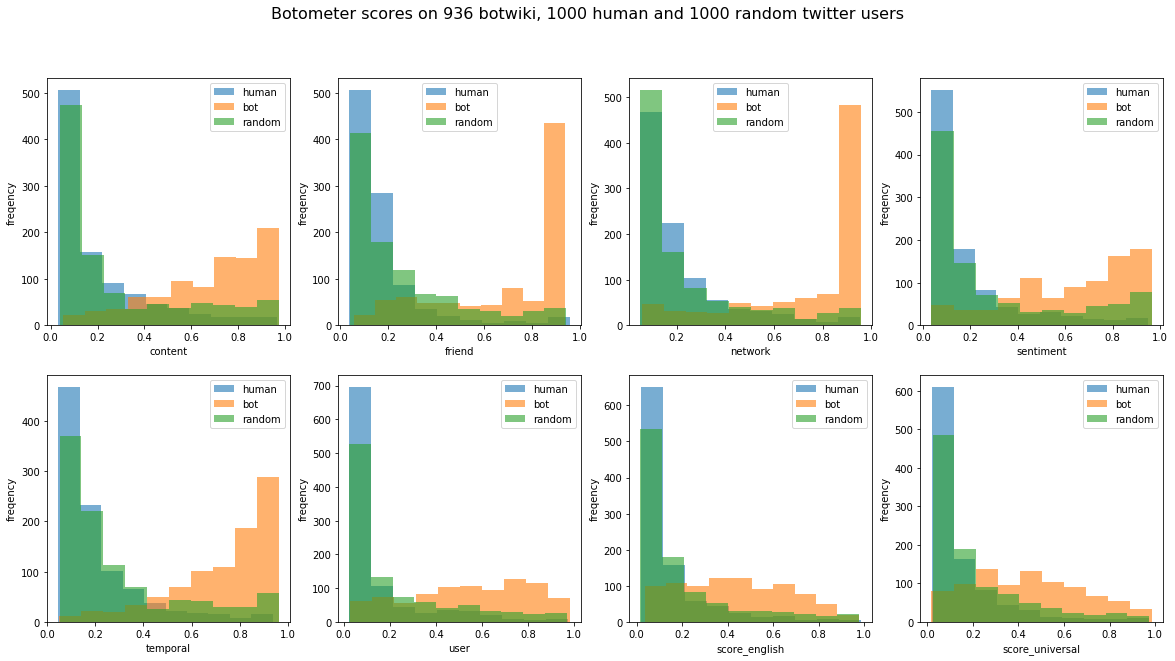

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
col = 3
for j in range(2):
    for i in range(4):
        axs[j,i].hist(human_score.iloc[:,col].tolist(), alpha=0.6, 
                      label='human')
        axs[j,i].hist(bot_score.iloc[:,col].tolist(), alpha=0.6, 
                      label='bot')
        axs[j,i].hist(random_score.iloc[:,col].tolist(), alpha=0.6, 
                      label='random')
        axs[j,i].set_ylabel('freqency') 
        axs[j,i].set_xlabel(human_score.columns[col])
        axs[j,i].legend()
        col=col+1

fig.suptitle("Botometer scores on 936 botwiki, 1000 human "\
             +"and 1000 random twitter users", fontsize=16)

fig.savefig('fig/Botometer scores distribution.png', format = 'png')

# Find the ratio of non-bot and bot in random set

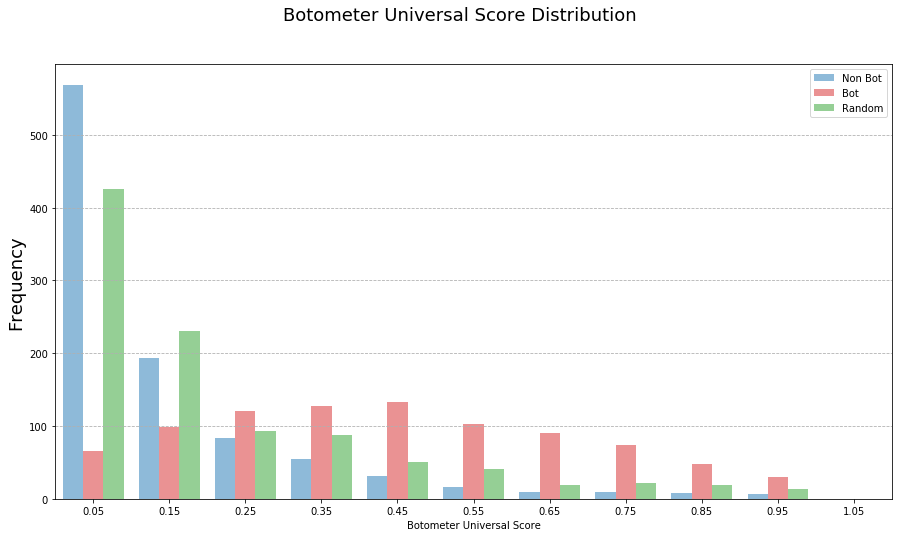

In [6]:
bins = np.arange(0,1.2,0.1)
plt.figure(figsize=(15, 8))
plt.hist([human_score.iloc[:,10].tolist(), 
          bot_score.iloc[:,10].tolist(),
          random_score.iloc[:,10].tolist()], 
         alpha=0.5, bins=bins, color=['C0', 'C3', 'C2'], 
         label = ['Non Bot', 'Bot', 'Random'])
#plt.hist(, alpha=0.5, bins=bins, color='C3', label = 'Bot')
#plt.hist(, alpha=0.5, bins=bins, color='C2', label = 'Random')
plt.ylabel('Frequency', fontsize = 18) 
plt.xlabel('Botometer Universal Score')
plt.xticks(np.arange(-0.05, 1.1, 0.1))
plt.xlim([0,1.1])
plt.grid(axis='y', linestyle='--')
plt.legend()

plt.suptitle("Botometer Universal Score Distribution", fontsize = 18)
plt.savefig('fig/score_universal_distribution.png', format = 'png')
plt.savefig('../docs/assets/images/score_universal_distribution.png', 
            format = 'png')

In [7]:
np.random.seed(123456)
x = random_score['score_universal']
y = human_score['score_universal']
z = bot_score['score_universal']


print('difference between random and human')
print(ks_2samp(x, y))
print('difference between random and bot')
print(ks_2samp(x, z))

difference between random and human
Ks_2sampResult(statistic=0.1559714867617108, pvalue=5.175986131548254e-11)
difference between random and bot
Ks_2sampResult(statistic=0.47200000000000003, pvalue=1.3333627704181822e-92)


In [8]:
np.random.seed(123)

def loss_function_bot_ratio(bot_ratio):
    human_number =  int(len (x) * (1-bot_ratio))
    bot_number = int (len (x) * bot_ratio)
    mix = np.random.choice(y,human_number).tolist() \
            + np.random.choice(z,bot_number).tolist()
    return ks_2samp(x, mix)[0]    

In [9]:
p_random_mix = []
for bot_ratio in np.arange(0, 1, 0.001):
    p = loss_function_bot_ratio(bot_ratio)
    p_random_mix.append(p)

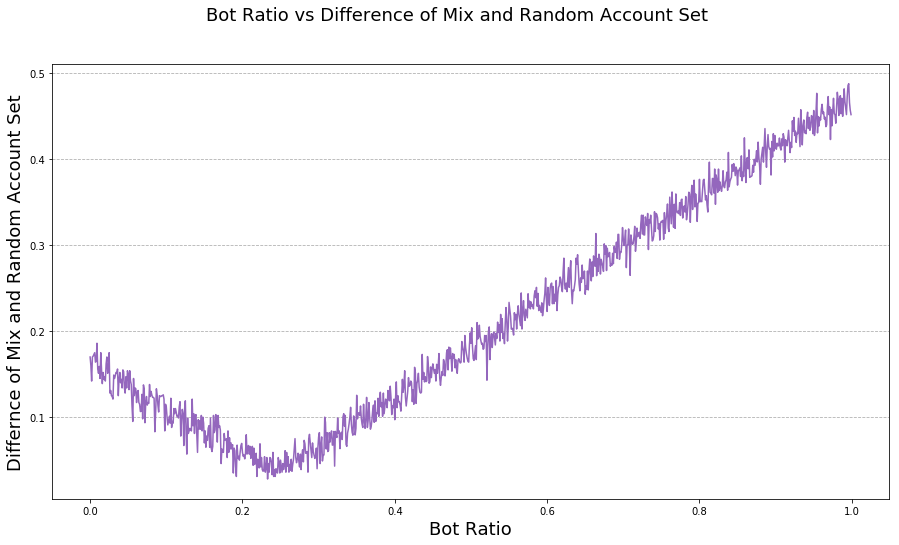

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(0, 1, 0.001),p_random_mix, color='C4')
plt.xlabel("Bot Ratio", fontsize = 18)
plt.ylabel("Differnce of Mix and Random Account Set", fontsize = 18)
plt.grid(axis='y', linestyle='--')

plt.suptitle("Bot Ratio vs Difference of Mix and Random Account Set", 
             fontsize = 18)
plt.savefig('fig/bot_ratio.png', format = 'png')
plt.savefig('../docs/assets/images/bot_ratio.png', format = 'png')

In [11]:
best_bot_ratio = np.arange(0, 1, 0.001)\
                            [p_random_mix.index(min(p_random_mix))]
print("ratio of bot in random account set: ", best_bot_ratio)

ratio of bot in random account set:  0.233


# Determin botmeter score cutoff : logistic regression

In [12]:
len(human_score.sample(int (len (x) * best_bot_ratio)))

233

In [13]:
best_human_number = int(len(x)*(1-best_bot_ratio))
best_bot_number = int(len(x)*best_bot_ratio)
                        
human_bot_score_df =  human_score.sample(best_human_number)\
                        .append(bot_score.sample(best_bot_number))
len (human_bot_score_df)
print("training data including mixing of:")
print("verified human: ",best_human_number,
      " bot:",best_bot_number, 
      " total: ",len(human_bot_score_df))

training data including mixing of:
verified human:  767  bot: 233  total:  1000


In [14]:
X_data = human_bot_score_df.iloc[:,10:11]
y_data = pd.get_dummies(human_bot_score_df['is_bot'], 
                        drop_first=True)['Ture']

X_train, X_test = train_test_split(X_data, test_size = 0.2, 
                                   random_state=90)
y_train, y_test = train_test_split(y_data, test_size = 0.2, 
                                   random_state=90)

In [15]:
def perfromance(model,X_train,X_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    #Perfromance Evaluation
    train_score = accuracy_score(y_train, y_pred_train)*100
    test_score = accuracy_score(y_test, y_pred_test)*100

    print("logistic regression model")
    print("Training Set Accuracy:",str(train_score)+'%')
    print("Testing Set Accuracy:",str(test_score)+'%')

    print()
    print("Rows: True Lables (0,1), \nColummns: Predicted Lables (0,1)")
    print("human","bot")

    print("train:")
    print(confusion_matrix(y_train, y_pred_train))
    print("test:")
    print(confusion_matrix(y_test, y_pred_test))

In [16]:
botometer_train_model = LogisticRegressionCV(Cs=10, cv=5)\
                                            .fit(X_train, y_train)
perfromance(botometer_train_model,X_train,X_test)

logistic regression model
Training Set Accuracy: 83.375%
Testing Set Accuracy: 79.0%

Rows: True Lables (0,1), 
Colummns: Predicted Lables (0,1)
human bot
train:
[[582  35]
 [ 98  85]]
test:
[[141   9]
 [ 33  17]]


In [17]:
botometer_train_model = LogisticRegressionCV(Cs=10, cv=5)\
                                            .fit(X_data, y_data)

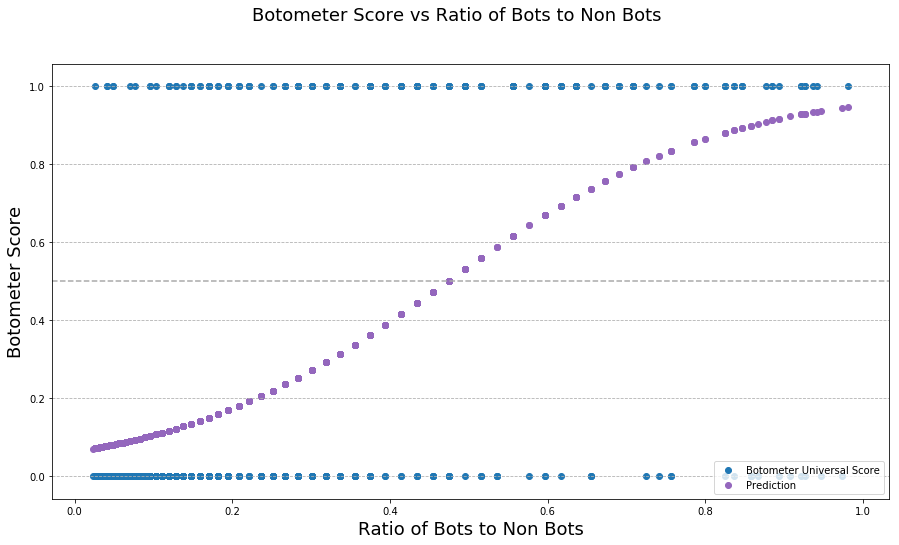

In [18]:
plt.figure(figsize=(15, 8))
plt.scatter(X_train, y_train, label = "Botometer Universal Score", 
            color='C0')
plt.scatter(X_train, botometer_train_model.predict_proba(X_train)[:,1], 
            label = "Prediction", color='C4')  
plt.axhline(y=0.5, color='darkgray', linestyle='--')
plt.xlabel("Ratio of Bots to Non Bots", fontsize = 18)
plt.ylabel("Botometer Score", fontsize = 18)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')

plt.suptitle("Botometer Score vs Ratio of Bots to Non Bots", 
             fontsize = 18)
plt.savefig('fig/bot_cutoff.png', format = 'png')
plt.savefig('../docs/assets/images/bot_cutoff.png', format = 'png')

In [19]:
diff = (abs(botometer_train_model.predict_proba(X_train)[:,1]-0.5))\
                                                    .tolist()
cut_off = X_train["score_universal"].tolist()[diff.index(min(diff))]

In [20]:
print ("best cut off of score_universal_botometer is", round(cut_off,2))

best cut off of score_universal_botometer is 0.47


# Read and clear data (1000 random accounts)

In [21]:
BOTOMETER_SCORE_THRESHOLD = 0.43

users_summary_df_gz_file = os.path.join('data',
                                        'users_final_agg_df.pkl.gz')
pd.set_option('display.max_colwidth', -1)

users_summary_df = pd.read_pickle(users_summary_df_gz_file, 
                                  compression = 'gzip')

In [22]:
pd.set_option('display.max_rows', 350)
pd.set_option('display.max_colwidth', -1)

print(users_summary_df.shape)
display(users_summary_df.describe())
display(users_summary_df.dtypes)


(1000, 95)


,favourites_count,followers_count,friends_count,listed_count,statuses_count,scores.universal,tweets_per_hour_00,tweets_per_hour_01,tweets_per_hour_02,tweets_per_hour_03,...,mean_links_to_top_sports,mean_links_to_top_adult,retweet_ratio,mean_ref_to_person,mean_ref_to_norp,mean_ref_to_org,mean_ref_to_gpe,mean_ref_to_product,mean_ref_to_law,mean_ref_to_money
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,997.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,21331.004000,1867.186000,1139.991000,25.115000,31638.967000,0.212890,4.588000,5.02600,5.824000,6.759000,...,0.000330,0.000360,0.551745,0.182715,0.030457,0.196451,0.099081,0.008963,0.001363,0.001038
std,39114.780324,7344.047951,4073.343137,92.364381,59896.719907,0.215876,5.731763,6.70584,7.296318,8.590268,...,0.005534,0.005338,0.334117,0.178761,0.045421,0.152971,0.148220,0.015327,0.004268,0.003912
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.023519,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1550.250000,108.750000,167.000000,0.000000,2309.750000,0.060780,0.000000,0.00000,1.000000,1.000000,...,0.000000,0.000000,0.250000,0.080000,0.000000,0.100000,0.030000,0.000000,0.000000,0.000000
50%,7982.500000,363.000000,397.500000,2.000000,9648.500000,0.119570,3.000000,3.00000,4.000000,5.000000,...,0.000000,0.000000,0.600000,0.140000,0.018363,0.160000,0.070000,0.000000,0.000000,0.000000
75%,23129.750000,1094.500000,908.250000,11.000000,32057.500000,0.300817,6.000000,7.00000,8.000000,9.000000,...,0.000000,0.000000,0.860000,0.240000,0.040000,0.250000,0.120000,0.010000,0.000000,0.000000
max,383288.000000,100730.000000,85123.000000,1550.000000,624250.000000,0.972640,55.000000,49.00000,87.000000,87.000000,...,0.160000,0.130000,1.000000,3.000000,0.370000,2.080000,2.780000,0.160000,0.040000,0.047619


contributors_enabled                   bool   
created_at                             object 
default_profile                        bool   
default_profile_image                  bool   
description                            object 
entities.description.urls              object 
entities.url.urls                      object 
favourites_count                       int64  
follow_request_sent                    bool   
followers_count                        int64  
following                              bool   
friends_count                          int64  
geo_enabled                            bool   
has_extended_profile                   bool   
id_str                                 object 
is_translation_enabled                 bool   
is_translator                          bool   
lang                                   object 
listed_count                           int64  
location                               object 
name                                   object 
notifications

In [23]:
users = users_summary_df.copy()

In [24]:
type_bool = []
type_int = []
type_float = []
type_other = []
for i in range(len(users.dtypes)):
    if users.dtypes[i] == 'bool':
        type_bool.append(i)
    if users.dtypes[i] == 'int64':
        type_int.append(i)
    if users.dtypes[i] == 'float64':
        type_float.append(i)
    if users.dtypes[i]!= 'bool' \
                            and users.dtypes[i]!= 'int64' \
                            and users.dtypes[i]!= 'float64':
        type_other.append(i)
print (len(type_bool),len(type_int),len(type_float),len(type_other))


14 5 51 25


In [25]:
users_clear = users.iloc[:,([43,14,20,7, 9, 11, 18, 36] \
                            + type_float[1:]+[2,3,12,13,15,25,33,41])]
users_clear.index = range(1000)
print(users_clear.shape)
print(users_clear.columns)

(1000, 66)
Index(['scores.universal', 'id_str', 'name', 'favourites_count',
       'followers_count', 'friends_count', 'listed_count', 'statuses_count',
       'tweets_per_hour_00', 'tweets_per_hour_01', 'tweets_per_hour_02',
       'tweets_per_hour_03', 'tweets_per_hour_04', 'tweets_per_hour_05',
       'tweets_per_hour_06', 'tweets_per_hour_07', 'tweets_per_hour_08',
       'tweets_per_hour_09', 'tweets_per_hour_10', 'tweets_per_hour_11',
       'tweets_per_hour_12', 'tweets_per_hour_13', 'tweets_per_hour_14',
       'tweets_per_hour_15', 'tweets_per_hour_16', 'tweets_per_hour_17',
       'tweets_per_hour_18', 'tweets_per_hour_19', 'tweets_per_hour_20',
       'tweets_per_hour_21', 'tweets_per_hour_22', 'tweets_per_hour_23',
       'mean_links_per_tweet', 'mean_words_per_tweet',
       'mean_hashtags_per_tweet', 'mean_user_mentions_per_tweet',
       'mean_favourites_per_tweet', 'mean_media_per_tweet',
       'mean_user_symbols_per_tweet', 'mean_retweets_per_tweet',
       'mean_trun

In [26]:
X_data = users_clear.iloc[:,3:]
y_data = []
bot_number = 0
for i in range(len(users_clear)):    
    if users_clear['scores.universal'][i] >= BOTOMETER_SCORE_THRESHOLD:
            y_data = y_data + [1]
            bot_number =bot_number +1
    else: y_data = y_data + [0]
print(X_data.shape, len(y_data))
print("bot number:" ,bot_number)

(1000, 63) 1000
bot number: 149


In [27]:
X_train, X_test = train_test_split(X_data, 
                                   test_size = 0.2, 
                                   random_state=90)
y_train, y_test = train_test_split(y_data, 
                                   test_size = 0.2, 
                                   random_state=90)

# Logistic Regresion

In [28]:
def perfromance(model,X_train,X_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    #Perfromance Evaluation
    train_score = accuracy_score(y_train, y_pred_train)*100
    train_matrix = confusion_matrix(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)*100
    test_matrix = confusion_matrix(y_test, y_pred_test)
    
    train_ture_negative = train_matrix[0][0]\
                            /(train_matrix[0][0]+train_matrix[0][1])*100
    train_ture_positive = train_matrix[1][1]\
                            /(train_matrix[1][0]+train_matrix[1][1])*100
    
    test_ture_negative = test_matrix[0][0]\
                            /(test_matrix[0][0]+test_matrix[0][1])*100
    test_ture_positive = test_matrix[1][1]\
                            /(test_matrix[1][0]+test_matrix[1][1])*100

    print()
    print("Rows: True Lables (0,1), \nColummns: Predicted Lables (0,1)")
    print("human","bot")

    print("train:")
    print(train_matrix)
    print("test:")
    print(test_matrix)
    
    print("Training Set total accuracy:",str(train_score)+'%')    
    print("Training Set non-bot accuracy:",str(train_ture_negative)+'%')    
    print("Training Set bot accuracy:",str(train_ture_positive)+'%')
    
    print("Test Set accuracy:",str(test_score)+'%')    
    print("Test Set non-bot accuracy:",str(test_ture_negative)+'%')    
    print("Test Set bot accuracy:",str(test_ture_positive)+'%')

In [29]:
def tuning_bot_weight(bot_weight):
    model = LogisticRegressionCV(Cs=10, cv=5,max_iter=1000, 
                                 class_weight = {0:1,1:bot_weight})\
                                                    .fit(X_train, 
                                                         y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_score = accuracy_score(y_train, y_pred_train)*100
    train_matrix = confusion_matrix(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)*100
    test_matrix = confusion_matrix(y_test, y_pred_test)
    
    train_ture_negative = train_matrix[0][0]\
                            /(train_matrix[0][0]+train_matrix[0][1])*100
    train_ture_positive = train_matrix[1][1]\
                            /(train_matrix[1][0]+train_matrix[1][1])*100
    
    test_ture_negative = test_matrix[0][0]\
                            /(test_matrix[0][0]+test_matrix[0][1])*100
    test_ture_positive = test_matrix[1][1]\
                            /(test_matrix[1][0]+test_matrix[1][1])*100
    
    accuracy = [bot_weight, train_score, train_ture_negative, 
                train_ture_positive, test_score, test_ture_negative, 
                test_ture_positive]
    return accuracy

In [30]:
bot_weight_accuracy = []
for bot_weight in range(5,11):
    bot_weight_accuracy.append(tuning_bot_weight(bot_weight))
bot_weight_accuracy = pd.DataFrame(bot_weight_accuracy, 
                                   columns =['bot_weight', 
                                             'train_score', 
                                             'train_ture_negative', 
                                             'train_ture_positive', 
                                             'test_score', 
                                             'test_ture_negative', 
                                             'test_ture_positive'] )

/Users/blair/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


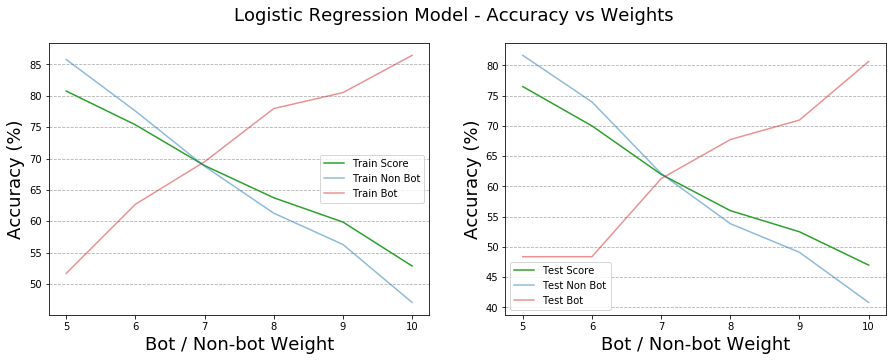

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].plot(bot_weight_accuracy.iloc[:,0],bot_weight_accuracy.iloc[:,1], 
            label='Train Score', color='C2')
axs[0].plot(bot_weight_accuracy.iloc[:,0],bot_weight_accuracy.iloc[:,2], 
            label='Train Non Bot', color='C0', alpha=0.5)
axs[0].plot(bot_weight_accuracy.iloc[:,0],bot_weight_accuracy.iloc[:,3], 
            label='Train Bot', color='C3', alpha=0.5)
axs[0].set_xlabel('Bot / Non-bot Weight', fontsize = 18) 
axs[0].set_ylabel('Accuracy (%)', fontsize = 18) 
axs[0].legend()
axs[0].grid(axis='y', linestyle='--')


axs[1].plot(bot_weight_accuracy.iloc[:,0],bot_weight_accuracy.iloc[:,4], 
            label='Test Score', color='C2')
axs[1].plot(bot_weight_accuracy.iloc[:,0],bot_weight_accuracy.iloc[:,5], 
            label='Test Non Bot', color='C0', alpha=0.5)
axs[1].plot(bot_weight_accuracy.iloc[:,0],bot_weight_accuracy.iloc[:,6], 
            label='Test Bot', color='C3', alpha=0.5)
axs[1].set_xlabel('Bot / Non-bot Weight', fontsize = 18) 
axs[1].set_ylabel('Accuracy (%)', fontsize = 18)
axs[1].legend()
axs[1].grid(axis='y', linestyle='--')


fig.suptitle("Logistic Regression Model - Accuracy vs Weights", 
             fontsize=18)
plt.savefig('../docs/assets/images/log_regression_model.png',
            format = 'png')
fig.savefig('fig/log_regression_model.png', format = 'png')

In [32]:
LR_model = LogisticRegressionCV(Cs=10, cv=5,max_iter=1000, 
                                class_weight = {0:1,1:7}).fit(X_train, 
                                                              y_train)
perfromance(LR_model,X_train,X_test)


Rows: True Lables (0,1), 
Colummns: Predicted Lables (0,1)
human bot
train:
[[469 213]
 [ 36  82]]
test:
[[105  64]
 [ 12  19]]
Training Set total accuracy: 68.875%
Training Set non-bot accuracy: 68.76832844574781%
Training Set bot accuracy: 69.49152542372882%
Test Set accuracy: 62.0%
Test Set non-bot accuracy: 62.1301775147929%
Test Set bot accuracy: 61.29032258064516%


# Random Forest

In [33]:
n_trees = 50
tree_depth = 5
RF_model = RandomForestClassifier(n_estimators=n_trees, 
                                 max_depth=tree_depth,
                                 class_weight = {0:1,1:20}).fit(X_train,
                                                                y_train)

In [34]:
perfromance(RF_model,X_train,X_test)


Rows: True Lables (0,1), 
Colummns: Predicted Lables (0,1)
human bot
train:
[[589  93]
 [  2 116]]
test:
[[136  33]
 [  4  27]]
Training Set total accuracy: 88.125%
Training Set non-bot accuracy: 86.36363636363636%
Training Set bot accuracy: 98.30508474576271%
Test Set accuracy: 81.5%
Test Set non-bot accuracy: 80.4733727810651%
Test Set bot accuracy: 87.09677419354838%


In [35]:
def tuning_tree_depth(tree_depth):
    model = RandomForestClassifier(n_estimators=n_trees, 
                                max_depth=tree_depth,
                                class_weight = {0:1,1:20}).fit(X_train,
                                                                y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_score = accuracy_score(y_train, y_pred_train)*100
    train_matrix = confusion_matrix(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)*100
    test_matrix = confusion_matrix(y_test, y_pred_test)
    
    train_ture_negative = train_matrix[0][0]\
                            /(train_matrix[0][0]+train_matrix[0][1])*100
    train_ture_positive = train_matrix[1][1]\
                            /(train_matrix[1][0]+train_matrix[1][1])*100
    
    test_ture_negative = test_matrix[0][0]\
                            /(test_matrix[0][0]+test_matrix[0][1])*100
    test_ture_positive = test_matrix[1][1]\
                            /(test_matrix[1][0]+test_matrix[1][1])*100
    
    accuracy = [tree_depth, train_score, train_ture_negative, 
                train_ture_positive, test_score, test_ture_negative, 
                test_ture_positive]
    return accuracy

In [36]:
tree_depth_accuracy = []
for tree_depth in range(1,30):
    tree_depth_accuracy.append(tuning_tree_depth(tree_depth))
tree_depth_accuracy = pd.DataFrame(tree_depth_accuracy, 
                                   columns =['tree_depth', 
                                             'train_score', 
                                             'train_ture_negative', 
                                             'train_ture_positive', 
                                             'test_score', 
                                             'test_ture_negative', 
                                             'test_ture_positive'] )

In [37]:
tree_depth_accuracy.head()

,tree_depth,train_score,train_ture_negative,train_ture_positive,test_score,test_ture_negative,test_ture_positive
0,1,14.750,0.000000,100.0,15.5,0.000000,100.000000
1,2,18.250,4.105572,100.0,17.0,1.775148,100.000000
2,3,48.250,39.296188,100.0,48.5,39.053254,100.000000
3,4,72.375,67.595308,100.0,67.5,62.130178,96.774194
4,5,86.750,84.457478,100.0,79.5,78.106509,87.096774


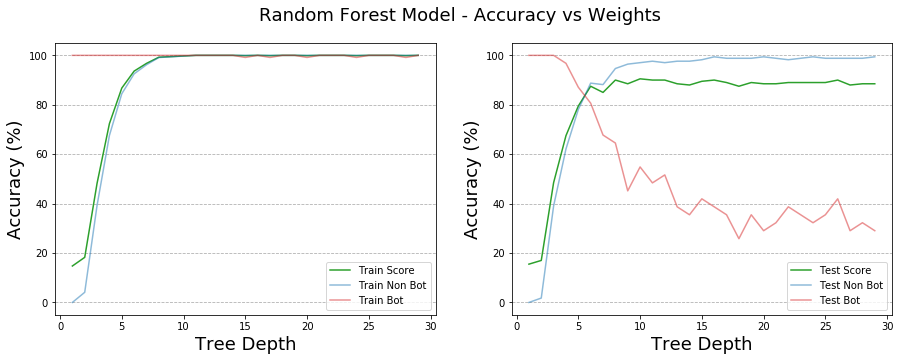

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(tree_depth_accuracy.iloc[:,0],tree_depth_accuracy.iloc[:,1], 
            label='Train Score', color='C2')
axs[0].plot(tree_depth_accuracy.iloc[:,0],tree_depth_accuracy.iloc[:,2], 
            label='Train Non Bot', color='C0', alpha=0.5)
axs[0].plot(tree_depth_accuracy.iloc[:,0],tree_depth_accuracy.iloc[:,3], 
            label='Train Bot', color='C3', alpha=0.5)
axs[0].set_xlabel('Tree Depth', fontsize=18) 
axs[0].set_ylabel('Accuracy (%)', fontsize=18) 
axs[0].legend()
axs[0].grid(axis='y', linestyle='--')

axs[1].plot(tree_depth_accuracy.iloc[:,0],tree_depth_accuracy.iloc[:,4], 
            label='Test Score', color='C2')
axs[1].plot(tree_depth_accuracy.iloc[:,0],tree_depth_accuracy.iloc[:,5], 
            label='Test Non Bot', color='C0', alpha=0.5)
axs[1].plot(tree_depth_accuracy.iloc[:,0],tree_depth_accuracy.iloc[:,6], 
            label='Test Bot', color='C3', alpha=0.5)
axs[1].set_xlabel('Tree Depth', fontsize=18) 
axs[1].set_ylabel('Accuracy (%)', fontsize=18) 
axs[1].legend()
axs[1].grid(axis='y', linestyle='--')


fig.suptitle("Random Forest Model - Accuracy vs Weights", fontsize=18)
fig.savefig('fig/rf_model.png', format = 'png')
plt.savefig('../docs/assets/images/rf_model.png', format = 'png')

The best tree_depth is 5.

In [39]:
tree_depth = 5
n_trees = 50
RF_model = RandomForestClassifier(n_estimators=n_trees, 
                                 max_depth=tree_depth,
                                 class_weight = {0:1,1:20}).fit(X_train,
                                                                y_train)
perfromance(RF_model,X_train,X_test)


Rows: True Lables (0,1), 
Colummns: Predicted Lables (0,1)
human bot
train:
[[575 107]
 [  0 118]]
test:
[[134  35]
 [  2  29]]
Training Set total accuracy: 86.625%
Training Set non-bot accuracy: 84.3108504398827%
Training Set bot accuracy: 100.0%
Test Set accuracy: 81.5%
Test Set non-bot accuracy: 79.28994082840237%
Test Set bot accuracy: 93.54838709677419%


# bagging decision tree


In [40]:
def perfromance_bagging():
    train_score = accuracy_score(y_train, y_pred_train)*100
    train_matrix = confusion_matrix(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)*100
    test_matrix = confusion_matrix(y_test, y_pred_test)
    
    train_ture_negative = train_matrix[0][0]\
                            /(train_matrix[0][0]+train_matrix[0][1])*100
    train_ture_positive = train_matrix[1][1]\
                            /(train_matrix[1][0]+train_matrix[1][1])*100
    
    test_ture_negative = test_matrix[0][0]\
                            /(test_matrix[0][0]+test_matrix[0][1])*100
    test_ture_positive = test_matrix[1][1]\
                            /(test_matrix[1][0]+test_matrix[1][1])*100

    print()
    print("Rows: True Lables (0,1), \nColummns: Predicted Lables (0,1)")
    print("human","bot")

    print("train:")
    print(train_matrix)
    print("test:")
    print(test_matrix)
    
    print("Training Set total accuracy:",str(train_score)+'%')    
    print("Training Set non-bot accuracy:",str(train_ture_negative)+'%')    
    print("Training Set bot accuracy:",str(train_ture_positive)+'%')
    
    print("Test Set accuracy:",str(test_score)+'%')    
    print("Test Set non-bot accuracy:",str(test_ture_negative)+'%')    
    print("Test Set bot accuracy:",str(test_ture_positive)+'%')

In [41]:
#Select overfit tree depth
tree_depth = 10
#Set number of trees
n_trees = 11

#Conduct bootstrapping and fit models to the date
np.random.seed(0)
bagging_train = np.zeros((X_train.shape[0], n_trees))
bagging_test = np.zeros((X_test.shape[0], n_trees))
bagging_models = []
for i in range(n_trees):
    bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
    fitted_model = DecisionTreeClassifier(max_depth=tree_depth, 
                                          class_weight = {0:1,1:1})\
                                                .fit(bootstrapped_X, 
                                                     bootstrapped_y)
    bagging_models.append(fitted_model)
    bagging_train[:,i] = fitted_model.predict(X_train)
    bagging_test[:,i] = fitted_model.predict(X_test)

#Get Predictions across all models
y_pred_train = np.mean(bagging_train, axis=1) > .5
y_pred_test = np.mean(bagging_test, axis=1) > .5

In [42]:
perfromance_bagging()


Rows: True Lables (0,1), 
Colummns: Predicted Lables (0,1)
human bot
train:
[[682   0]
 [ 21  97]]
test:
[[158  11]
 [ 12  19]]
Training Set total accuracy: 97.375%
Training Set non-bot accuracy: 100.0%
Training Set bot accuracy: 82.20338983050848%
Test Set accuracy: 88.5%
Test Set non-bot accuracy: 93.49112426035504%
Test Set bot accuracy: 61.29032258064516%


In [43]:
def tuning_n_trees(n_trees):
   #Conduct bootstrapping and fit models to the date
    np.random.seed(0)
    bagging_train = np.zeros((X_train.shape[0], n_trees))
    bagging_test = np.zeros((X_test.shape[0], n_trees))
    bagging_models = []
    for i in range(n_trees):
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(max_depth=tree_depth, 
                                              class_weight = {0:1,1:2})\
                                                    .fit(bootstrapped_X, 
                                                         bootstrapped_y)
        bagging_models.append(fitted_model)
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)

    #Get Predictions across all models
    y_pred_train = np.mean(bagging_train, axis=1) > .5
    y_pred_test = np.mean(bagging_test, axis=1) > .5
    
    train_score = accuracy_score(y_train, y_pred_train)*100
    train_matrix = confusion_matrix(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)*100
    test_matrix = confusion_matrix(y_test, y_pred_test)
    
    train_ture_negative = train_matrix[0][0]\
                            /(train_matrix[0][0]+train_matrix[0][1])*100
    train_ture_positive = train_matrix[1][1]\
                            /(train_matrix[1][0]+train_matrix[1][1])*100
    
    test_ture_negative = test_matrix[0][0]\
                            /(test_matrix[0][0]+test_matrix[0][1])*100
    test_ture_positive = test_matrix[1][1]\
                            /(test_matrix[1][0]+test_matrix[1][1])*100
    
    accuracy = [n_trees, train_score, train_ture_negative, 
                train_ture_positive, test_score, test_ture_negative, 
                test_ture_positive]
    return accuracy

In [44]:
bagging_n_tree_accuracy = []
for n_trees in range(1,50):
    bagging_n_tree_accuracy.append(tuning_n_trees(n_trees))
bagging_n_tree_accuracy = pd.DataFrame(bagging_n_tree_accuracy, 
                                       columns =['tree_depth', 
                                                 'train_score', 
                                                 'train_ture_negative', 
                                                 'train_ture_positive', 
                                                 'test_score', 
                                                 'test_ture_negative', 
                                                 'test_ture_positive'] )

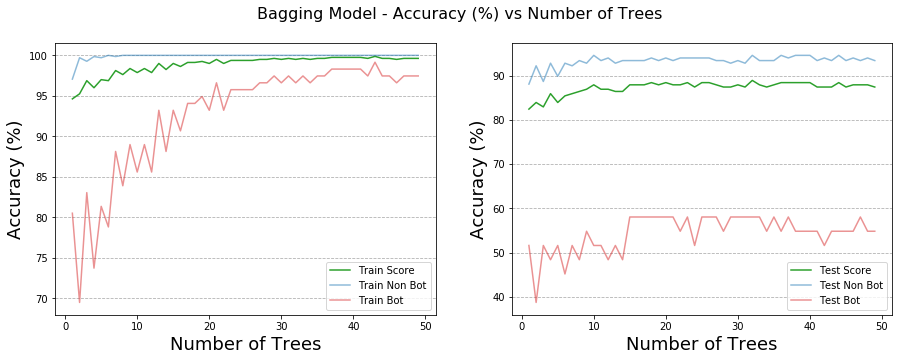

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(bagging_n_tree_accuracy.iloc[:,0],
            bagging_n_tree_accuracy.iloc[:,1], 
            label='Train Score', color='C2')
axs[0].plot(bagging_n_tree_accuracy.iloc[:,0],
            bagging_n_tree_accuracy.iloc[:,2], 
            label='Train Non Bot', color='C0', alpha=0.5)
axs[0].plot(bagging_n_tree_accuracy.iloc[:,0],
            bagging_n_tree_accuracy.iloc[:,3], 
            label='Train Bot', color='C3', alpha=0.5)
axs[0].set_xlabel('Number of Trees', fontsize=18) 
axs[0].set_ylabel('Accuracy (%)', fontsize=18) 
axs[0].legend()
axs[0].grid(axis='y', linestyle='--')

axs[1].plot(bagging_n_tree_accuracy.iloc[:,0],
            bagging_n_tree_accuracy.iloc[:,4], 
            label='Test Score', color='C2')
axs[1].plot(bagging_n_tree_accuracy.iloc[:,0],
            bagging_n_tree_accuracy.iloc[:,5], 
            label='Test Non Bot', color='C0', alpha=0.5)
axs[1].plot(bagging_n_tree_accuracy.iloc[:,0],
            bagging_n_tree_accuracy.iloc[:,6], 
            label='Test Bot', color='C3', alpha=0.5)
axs[1].set_xlabel('Number of Trees', fontsize=18) 
axs[1].set_ylabel('Accuracy (%)', fontsize=18) 
axs[1].legend()
axs[1].grid(axis='y', linestyle='--')


fig.suptitle("Bagging Model - Accuracy (%) vs Number of Trees", 
             fontsize=16)
fig.savefig('../docs/assets/images/bagging_model.png', format = 'png')
fig.savefig('fig/bagging_model.png', format = 'png')

In [46]:
def bagging_tuning_cut_off(cut_off):
   #Conduct bootstrapping and fit models to the date
    np.random.seed(0)
    bagging_train = np.zeros((X_train.shape[0], n_trees))
    bagging_test = np.zeros((X_test.shape[0], n_trees))
    bagging_models = []
    for i in range(n_trees):
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(max_depth=tree_depth, 
                                              class_weight = {0:1,1:2})\
                                                    .fit(bootstrapped_X, 
                                                         bootstrapped_y)
        bagging_models.append(fitted_model)
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)

    #Get Predictions across all models
    y_pred_train = np.mean(bagging_train, axis=1) > cut_off
    y_pred_test = np.mean(bagging_test, axis=1) > cut_off
    
    train_score = accuracy_score(y_train, y_pred_train)*100
    train_matrix = confusion_matrix(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)*100
    test_matrix = confusion_matrix(y_test, y_pred_test)
    
    train_ture_negative = train_matrix[0][0]\
                            /(train_matrix[0][0]+train_matrix[0][1])*100
    train_ture_positive = train_matrix[1][1]\
                            /(train_matrix[1][0]+train_matrix[1][1])*100
    
    test_ture_negative = test_matrix[0][0]\
                            /(test_matrix[0][0]+test_matrix[0][1])*100
    test_ture_positive = test_matrix[1][1]\
                            /(test_matrix[1][0]+test_matrix[1][1])*100
    
    accuracy = [cut_off, train_score, train_ture_negative, 
                train_ture_positive, test_score, test_ture_negative, 
                test_ture_positive]
    return accuracy

In [47]:
bagging_cut_off_accuracy = []
n_tree = 51
for cut_off in np.arange(0,0.5,0.05):
    bagging_cut_off_accuracy.append(bagging_tuning_cut_off(cut_off))
bagging_cut_off_accuracy = pd.DataFrame(bagging_cut_off_accuracy, 
                                        columns =['tree_depth', 
                                                  'train_score', 
                                                  'train_ture_negative', 
                                                  'train_ture_positive', 
                                                  'test_score', 
                                                  'test_ture_negative', 
                                                  'test_ture_positive'])

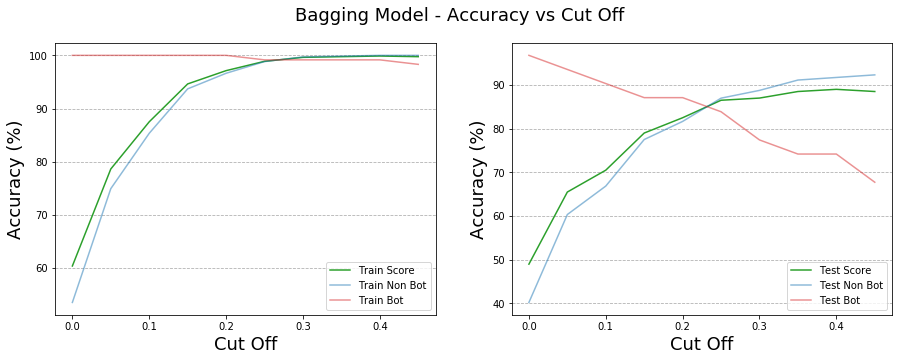

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(bagging_cut_off_accuracy.iloc[:,0],
            bagging_cut_off_accuracy.iloc[:,1], 
            label='Train Score', color='C2')
axs[0].plot(bagging_cut_off_accuracy.iloc[:,0],
            bagging_cut_off_accuracy.iloc[:,2], 
            label='Train Non Bot', color='C0', alpha=0.5)
axs[0].plot(bagging_cut_off_accuracy.iloc[:,0],
            bagging_cut_off_accuracy.iloc[:,3], 
            label='Train Bot', color='C3', alpha=0.5)
axs[0].set_xlabel('Cut Off', fontsize=18) 
axs[0].set_ylabel('Accuracy (%)', fontsize=18) 
axs[0].legend()
axs[0].grid(axis='y', linestyle='--')

axs[1].plot(bagging_cut_off_accuracy.iloc[:,0],
            bagging_cut_off_accuracy.iloc[:,4], 
            label='Test Score', color='C2')
axs[1].plot(bagging_cut_off_accuracy.iloc[:,0],
            bagging_cut_off_accuracy.iloc[:,5], 
            label='Test Non Bot', color='C0', alpha=0.5)
axs[1].plot(bagging_cut_off_accuracy.iloc[:,0],
            bagging_cut_off_accuracy.iloc[:,6], 
            label='Test Bot', color='C3', alpha=0.5)
axs[1].set_xlabel('Cut Off', fontsize=18) 
axs[1].set_ylabel('Accuracy (%)', fontsize=18) 
axs[1].legend()
axs[1].grid(axis='y', linestyle='--')

fig.suptitle("Bagging Model - Accuracy vs Cut Off", fontsize=18)
fig.savefig('../docs/assets/images/bagging_model_cut_off.png', 
            format = 'png')
fig.savefig('fig/bagging_model_cut_off.png', format = 'png')

In [49]:
#Select overfit tree depth
tree_depth = 10
#Set number of trees
n_trees = 51

#Conduct bootstrapping and fit models to the date
np.random.seed(0)
bagging_train = np.zeros((X_train.shape[0], n_trees))
bagging_test = np.zeros((X_test.shape[0], n_trees))
bagging_models = []
for i in range(n_trees):
    bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
    fitted_model = DecisionTreeClassifier(max_depth=tree_depth, 
                                          class_weight = {0:1,1:1})\
                                                .fit(bootstrapped_X, 
                                                     bootstrapped_y)
    bagging_models.append(fitted_model)
    bagging_train[:,i] = fitted_model.predict(X_train)
    bagging_test[:,i] = fitted_model.predict(X_test)

#Get Predictions across all models
y_pred_train = np.mean(bagging_train, axis=1) > .2
y_pred_test = np.mean(bagging_test, axis=1) > .2



In [50]:
perfromance_bagging()


Rows: True Lables (0,1), 
Colummns: Predicted Lables (0,1)
human bot
train:
[[663  19]
 [  1 117]]
test:
[[145  24]
 [  5  26]]
Training Set total accuracy: 97.5%
Training Set non-bot accuracy: 97.21407624633432%
Training Set bot accuracy: 99.15254237288136%
Test Set accuracy: 85.5%
Test Set non-bot accuracy: 85.79881656804734%
Test Set bot accuracy: 83.87096774193549%


# website frequency

In [51]:
predictions=pd.DataFrame(columns=['user_id',
                                  'user_name',
                                  'scores_universal',
                                  'is_bot_by_botometer',
                                  'mean_links_to_twitter',
                                  'mean_links_to_top_social_media', 
                                  'mean_links_to_top_digital_media',
                                  'mean_links_to_top_news', 
                                  'mean_links_to_top_products_services',
                                  'mean_links_to_top_celebrities', 
                                  'mean_links_to_top_organizations',
                                  'mean_links_to_top_sports', 
                                  'mean_links_to_top_adult',
                                  'prediction_lg',
                                  'prediction_RF',
                                  'prediction_bagging_tree'])

is_bot_by_botometer=y_data

In [52]:
predictions['user_id'] = users_summary_df['user.id_str']
predictions['user_name'] = users_summary_df['name']
predictions['scores_universal'] = users_summary_df['scores.universal']
predictions['is_bot_by_botometer'] = is_bot_by_botometer

for i in ['mean_links_to_twitter',
          'mean_links_to_top_social_media', 
          'mean_links_to_top_digital_media',
          'mean_links_to_top_news', 
          'mean_links_to_top_products_services',
          'mean_links_to_top_celebrities', 
          'mean_links_to_top_organizations',
          'mean_links_to_top_sports', 
          'mean_links_to_top_adult']:
    predictions[i] = users_summary_df[i]
predictions.index = range(1000)

In [53]:
train_index = X_train.index.tolist()
test_index = X_test.index.tolist()
index = train_index + test_index
y_pred_bag = pd.DataFrame(y_pred_train.tolist() + y_pred_test.tolist())
y_pred_bag.columns = ['pred_bag']
y_pred_bag.index = index
y_pred_bag = y_pred_bag.sort_index()
y_pred_bag = pd.get_dummies(y_pred_bag['pred_bag'], drop_first=True)
y_pred_bag.columns = ['pred_bag']

In [54]:
predictions['prediction_lg'] = LR_model.predict(X_data)
predictions['prediction_RF'] = RF_model.predict(X_data)
predictions['prediction_bagging_tree'] = y_pred_bag['pred_bag']

In [55]:
vote = []
for i in range(len(predictions)):
    if np.mean(predictions.iloc[i,-4:-1]) > 0.5:
        vote = vote + [1]
    else: vote = vote + [0]

In [56]:
vote = []
for i in range(len(predictions)):
    if np.mean(predictions.iloc[i,-4:-1]) > 0.5:
        vote = vote + [1]
    else: vote = vote + [0]

In [57]:
predict_bot_index=predictions.index[predictions['prediction_RF']==1]
predict_non_bot_index=predictions.index[predictions['prediction_RF']==0]

In [58]:
total_website_sum = []
bot_website_sum = []
ratio = []

for i in ['mean_links_to_twitter',
          'mean_links_to_top_social_media', 
          'mean_links_to_top_digital_media',
          'mean_links_to_top_news', 
          'mean_links_to_top_products_services',
          'mean_links_to_top_celebrities', 
          'mean_links_to_top_organizations',
          'mean_links_to_top_sports', 
          'mean_links_to_top_adult']:
    total_website_sum = total_website_sum + [sum(predictions[i])]
    bot_website_sum = bot_website_sum \
                        + [sum(predictions[i][predict_bot_index])]
    ratio = ratio + [sum(predictions[i][predict_bot_index])\
                        /sum(predictions[i])]
    
total_website_sum = total_website_sum + [sum(total_website_sum)]  
bot_website_sum = bot_website_sum + [sum(bot_website_sum)]  
ratio = ratio + [sum(bot_website_sum)/sum(total_website_sum)] 

In [59]:
bot_website_ratio = pd.DataFrame(ratio)
bot_website_ratio.index = ['mean_links_to_twitter',
                           'mean_links_to_top_social_media', 
                           'mean_links_to_top_digital_media',
                           'mean_links_to_top_news', 
                           'mean_links_to_top_products_services',
                           'mean_links_to_top_celebrities', 
                           'mean_links_to_top_organizations',
                           'mean_links_to_top_sports', 
                           'mean_links_to_top_adult',
                           'Total']


In [60]:
bot_website_ratio.iloc[0:9].sort_values(by=[0])

,0
mean_links_to_top_sports,0.090909
mean_links_to_twitter,0.208805
mean_links_to_top_celebrities,0.393511
mean_links_to_top_digital_media,0.454819
mean_links_to_top_social_media,0.555639
mean_links_to_top_news,0.593913
mean_links_to_top_products_services,0.621033
mean_links_to_top_organizations,0.967320
mean_links_to_top_adult,1.000000


In [61]:
bot_website_ratio_each = bot_website_ratio.iloc[0:9].sort_values(by=[0])
bot_website_ratio_total= bot_website_ratio.iloc[9:10]
bot_website_ratio_total[0] 

Total    0.293066
Name: 0, dtype: float64

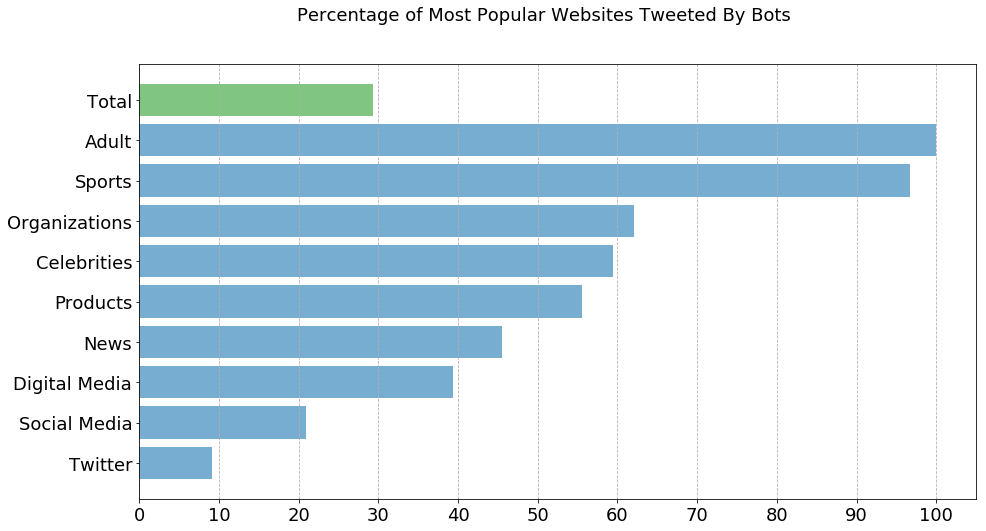

In [62]:
plt.figure(figsize=(15, 8))
plt.barh(range(9),bot_website_ratio_each[0] * 100, alpha = 0.6, 
         color = 'C0')
plt.barh(9,bot_website_ratio_total[0] * 100, alpha = 0.6, 
         color = 'C2')
plt.yticks(range(10), ['Twitter',
       'Social Media', 'Digital Media',
       'News', 'Products',
       'Celebrities', 'Organizations',
       'Sports', 'Adult','Total'], fontsize = 18)
plt.xticks(range(0,110,10),fontsize=18)
plt.grid(axis='x', linestyle='--')

plt.suptitle("Percentage of Most Popular Websites Tweeted By Bots", 
             fontsize=18)
plt.savefig('fig/websites.png', format = 'png')
plt.savefig('../docs/assets/images/websites.png', 
            format = 'png')
plt.show()